In [33]:
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn

from tqdm.notebook import tqdm
import csv

In [34]:
# Helper functions

def rotate(X, angle):
    '''
    Rotate the dataset X by the angle.
    '''
    rad = np.radians(angle)
    R = np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]])
    X_rotated = X.dot(R)
    return X_rotated

def plot_decision_boundary(model, X, y, steps=1000, color_map='Paired'):
    '''
    Plot the decision boundary of a model.
    '''
    x_min = X[:, 0].min() - 1
    x_max = X[:, 0].max() + 1
    y_min = X[:, 1].min() - 1
    y_max = X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))
    X_grid = np.c_[xx.ravel(), yy.ravel()]

    model.eval()
    y_boundary = model(torch.from_numpy(X_grid).float()).detach().numpy().round()
    y_boundary = np.array(y_boundary).reshape(xx.shape)

    color_map = plt.get_cmap(color_map)
    plt.contourf(xx, yy, y_boundary, cmap=color_map, alpha=0.5)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    class_1 = [X[y==0,0], X[y==0,1]]
    class_2 = [X[y==1,0], X[y==1,1]]
    plt.scatter(class_1[0], class_1[1], color=color_map.colors[1], marker='o')
    plt.scatter(class_2[0], class_2[1], color=color_map.colors[11], marker='x')

    plt.legend(["0","1"])
    plt.show()

def load_model(model, angle, i):
    model = MLP()
    model.load_state_dict(torch.load(f"models/model_{angle}_{i}.pth"))
    return model

In [35]:
# Dataset
X,y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=42)

# Normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

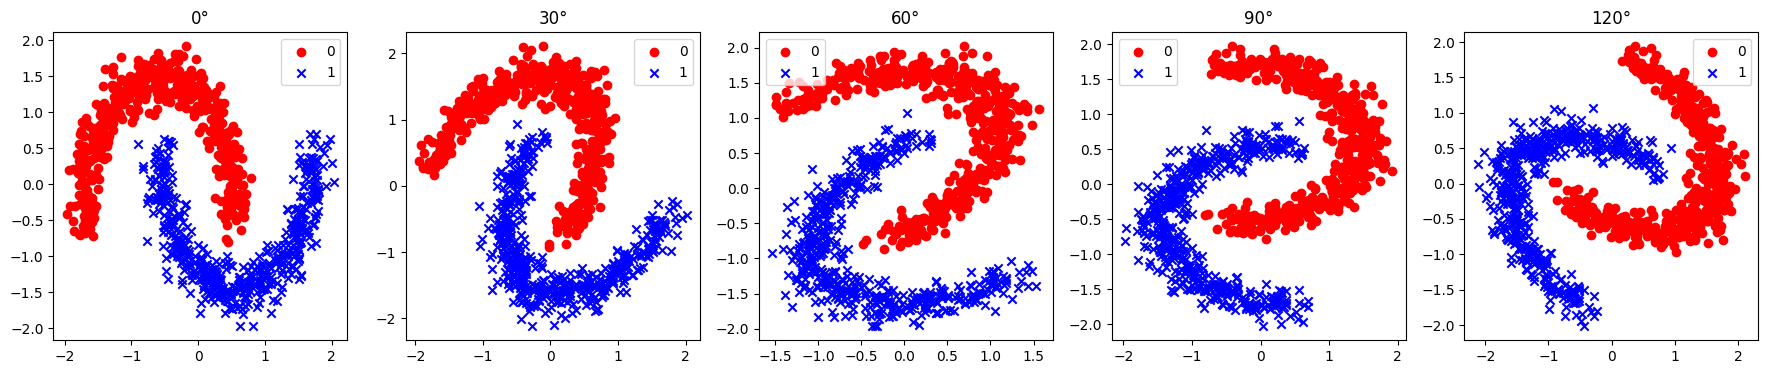

In [36]:
# Vizualization of different rotations
angles = [0, 30, 60, 90, 120]

fig, ax = plt.subplots(1, 5, figsize=(22, 4))

for i, angle in enumerate(angles):
    X_rotated = rotate(X, angle)
    ax[i].scatter(X_rotated[y==0,0], X_rotated[y==0,1], color='red', marker='o')
    ax[i].scatter(X_rotated[y==1,0], X_rotated[y==1,1], color='blue', marker='x')
    ax[i].legend(["0","1"])
    ax[i].set_title(f"{angle}°")

plt.show()

In [37]:
# Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

In [41]:
# Hyperparameters
angles = list(range(0, 360, 5))
models_per_angle = 10
epochs = 500
learning_rate = 0.01

# Logging
torch.manual_seed(42)
logs = []
models_path = "models"

# Training
for angle in tqdm(angles):
    for i in range(models_per_angle):
        model = MLP()
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        X_rotated = rotate(X, angle)
        X_tensor = torch.tensor(X_rotated, dtype=torch.float32)
        y_tensor = torch.tensor(y.reshape(-1,1), dtype=torch.float32)

        for epoch in range(epochs):
            y_pred = model(X_tensor)
            loss = criterion(y_pred, y_tensor)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        model.eval()
        y_pred = model(X_tensor).detach().numpy().round().flatten()
        correct = (y_pred == y).sum()
        accuracy = correct / len(y) * 100
        logs.append([angle, i, accuracy])

        torch.save(model.state_dict(), f"{models_path}/model_{angle}_{i}.pth")


with(open("logs.csv", "w")) as f:
    writer = csv.writer(f, lineterminator = '\n')
    writer.writerow(["angle", "model", "accuracy"])
    writer.writerows(logs)

  0%|          | 0/72 [00:00<?, ?it/s]

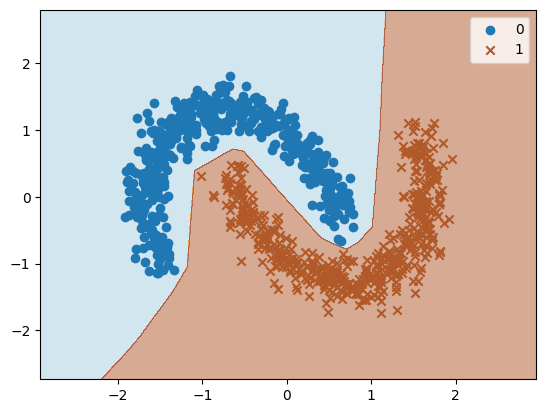

In [42]:
angle = 345
model = load_model(model, angle, 1)
plot_decision_boundary(model, rotate(X,angle), y)